## Part1: Gravity Gradient and Dzhanibekov Effect

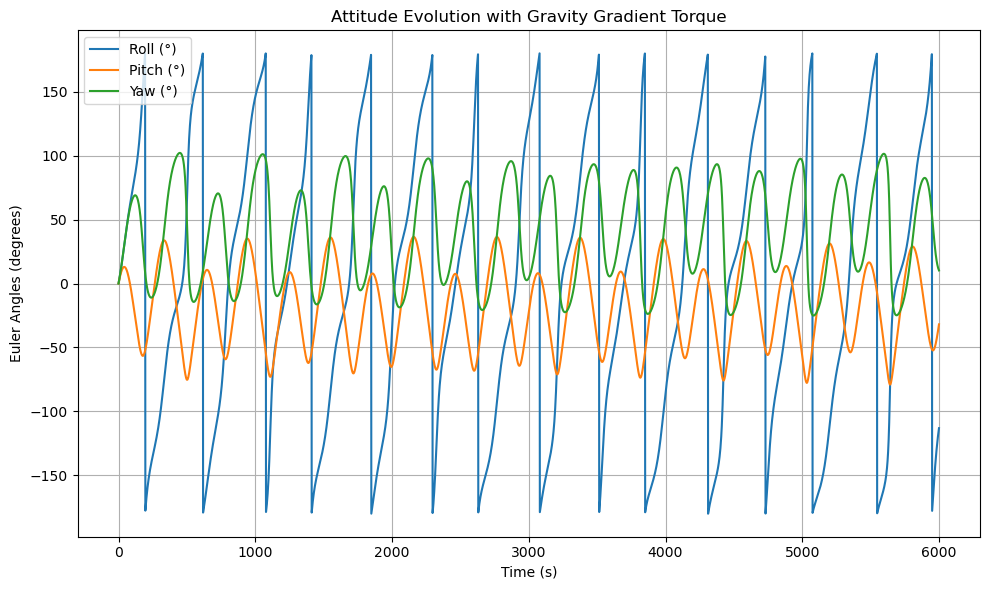

In [3]:
%reset -f
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# === Constants ===
mu = 3.986e14        # Earth's gravitational parameter (m³/s²)
Re = 6371e3          # Earth's radius (m)
h = 500e3            # Orbit altitude (m)
r = Re + h           # Orbital radius (m)
omega_orbit = np.sqrt(mu / r**3)  # Mean motion (rad/s)

# === Inertia matrix ===
Ix, Iy, Iz = 200, 150, 100  # kg·m²
I = np.diag([Ix, Iy, Iz])
I_inv = np.linalg.inv(I)

# === Initial Conditions ===
w0 = np.array([0.01, 0.01, 0.01])      # Small impulse about (rad/s)
q0 = np.array([1.0, 0.001, 0.0, 0.0])   # Initial quaternion (identity)
state0 = np.concatenate((w0, q0))     # Initial state vector

# === Quaternion Utilities ===
def quat_mult(q, r):
    w0, x0, y0, z0 = q
    w1, x1, y1, z1 = r
    return np.array([
        w0*w1 - x0*x1 - y0*y1 - z0*z1,
        w0*x1 + x0*w1 + y0*z1 - z0*y1,
        w0*y1 - x0*z1 + y0*w1 + z0*x1,
        w0*z1 + x0*y1 - y0*x1 + z0*w1
    ])

def quat_derivative(q, w):
    w_quat = np.concatenate(([0], w))
    return 0.5 * quat_mult(q, w_quat)

# === Gravity Gradient Torque ===
def gravity_gradient_torque(I, q):
    z_eci = np.array([0, 0, -1])
    q_conj = np.array([q[0], -q[1], -q[2], -q[3]])
    z_body = quat_mult(quat_mult(q_conj, np.concatenate(([0], z_eci))), q)[1:]
    return 3 * omega_orbit**2 * np.cross(z_body, I @ z_body)

# === Dynamics ===
def dynamics(t, state):
    w = state[0:3]
    q = state[3:7]

    Tgg = gravity_gradient_torque(I, q)
    w_dot = I_inv @ (Tgg - np.cross(w, I @ w))
    q_dot = quat_derivative(q, w)

    return np.concatenate((w_dot, q_dot))

# === Normalized Integration Wrapper ===
def integrate_with_quat_normalization(fun, t_span, y0, t_eval):
    def wrapped_fun(t, y):
        dydt = fun(t, y)
        dydt[3:7] -= (np.dot(y[3:7], dydt[3:7]) / np.dot(y[3:7], y[3:7])) * y[3:7]  # keep q unit norm
        return dydt

    sol = solve_ivp(wrapped_fun, t_span, y0, t_eval=t_eval, rtol=1e-8, atol=1e-10)

    # Normalize quaternion after each step
    for i in range(sol.y.shape[1]):
        q = sol.y[3:7, i]
        sol.y[3:7, i] = q / np.linalg.norm(q)
    return sol

# === Run Simulation ===
t_span = (0, 6000)                          # Simulate for ~5.5 hours
t_eval = np.linspace(*t_span, 3000)          # 4000 time points
sol = integrate_with_quat_normalization(dynamics, t_span, state0, t_eval)

# === Convert to Euler Angles ===
def quaternion_to_euler(q):
    w, x, y, z = q
    roll = np.arctan2(2*(w*x + y*z), 1 - 2*(x**2 + y**2))
    pitch = np.arcsin(2*(w*y - z*x))
    yaw = np.arctan2(2*(w*z + x*y), 1 - 2*(y**2 + z**2))
    return np.degrees([roll, pitch, yaw])

euler_angles = np.array([quaternion_to_euler(sol.y[3:7, i]) for i in range(sol.y.shape[1])])

# === Plot ===
plt.figure(figsize=(10, 6))
plt.plot(sol.t, euler_angles[:, 0], label='Roll (°)')
plt.plot(sol.t, euler_angles[:, 1], label='Pitch (°)')
plt.plot(sol.t, euler_angles[:, 2], label='Yaw (°)')
plt.xlabel("Time (s)")
plt.ylabel("Euler Angles (degrees)")
plt.title("Attitude Evolution with Gravity Gradient Torque")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('Part 1.png', format='png', dpi=300)
plt.show()



## Part 2: Applying Kalman Filter

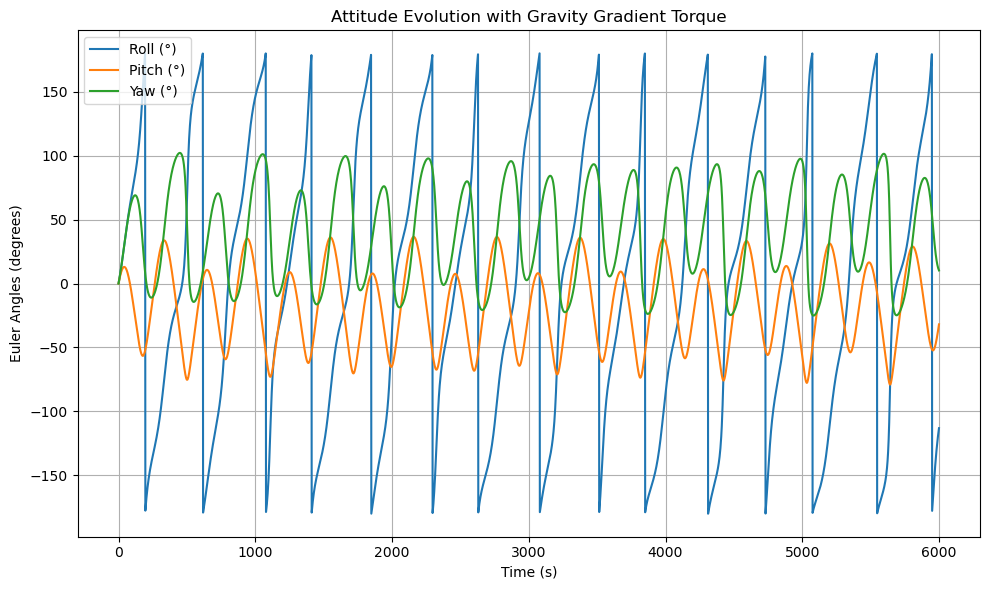

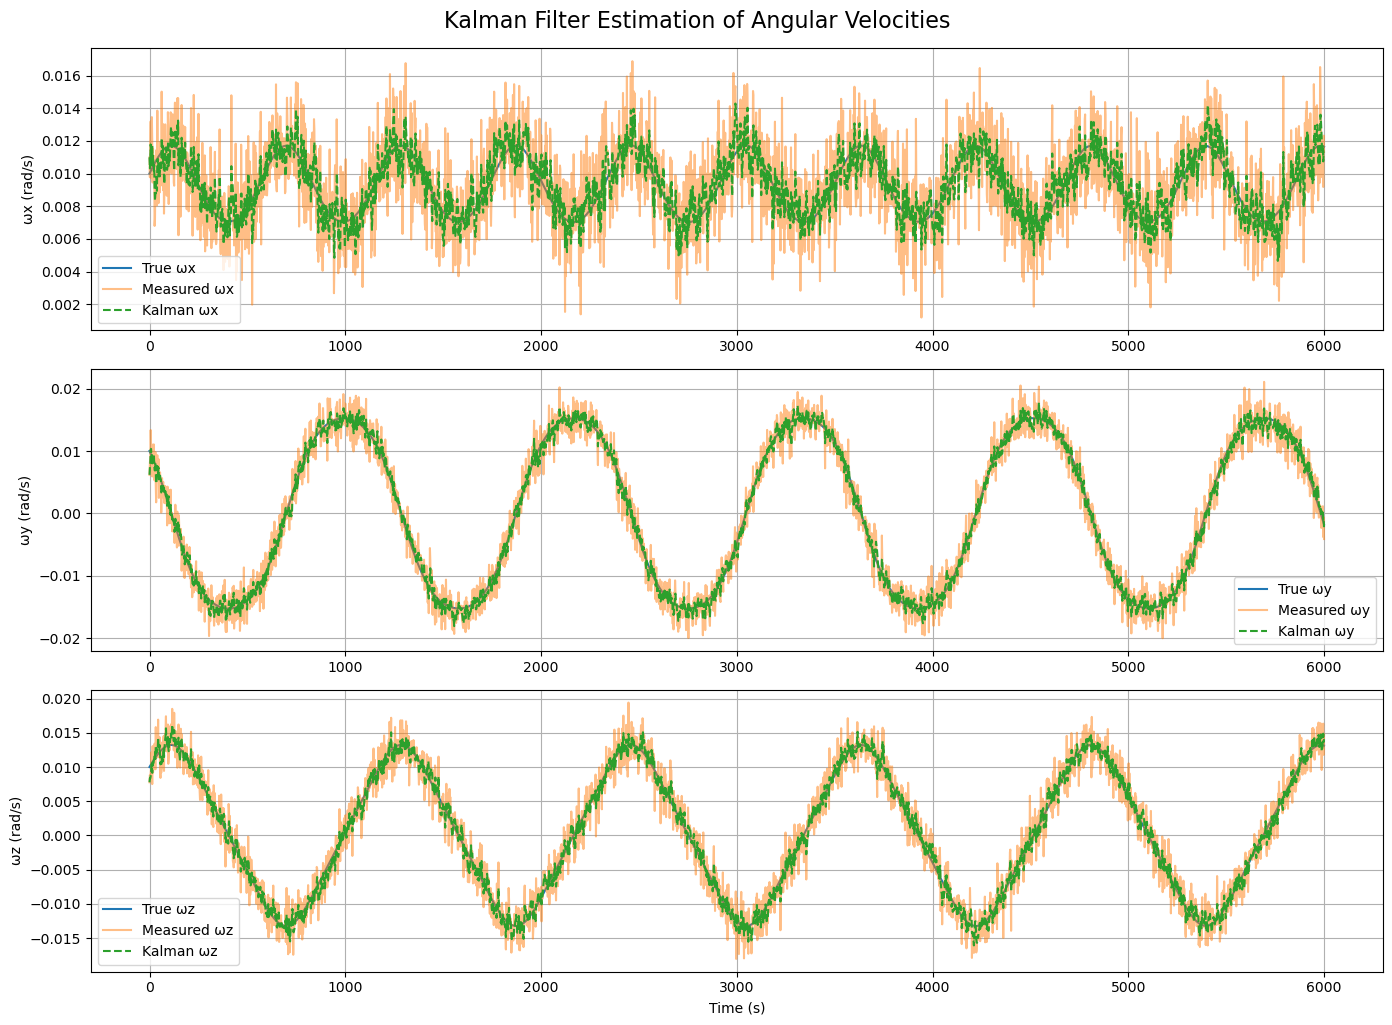

In [4]:
%reset -f
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# === Constants ===
mu = 3.986e14        # Earth's gravitational parameter (m³/s²)
Re = 6371e3          # Earth's radius (m)
h = 500e3            # Orbit altitude (m)
r = Re + h           # Orbital radius (m)
omega_orbit = np.sqrt(mu / r**3)  # Mean motion (rad/s)

# === Inertia matrix ===
Ix, Iy, Iz = 200, 150, 100  # kg·m²
I = np.diag([Ix, Iy, Iz])
I_inv = np.linalg.inv(I)

# === Initial Conditions ===
w0 = np.array([0.01, 0.01, 0.01])      # Small impulse (rad/s)
q0 = np.array([1.0, 0.001, 0.0, 0.0])   # Initial quaternion (identity)
state0 = np.concatenate((w0, q0))     # Initial state vector

# === Quaternion Utilities ===
def quat_mult(q, r):
    w0, x0, y0, z0 = q
    w1, x1, y1, z1 = r
    return np.array([
        w0*w1 - x0*x1 - y0*y1 - z0*z1,
        w0*x1 + x0*w1 + y0*z1 - z0*y1,
        w0*y1 - x0*z1 + y0*w1 + z0*x1,
        w0*z1 + x0*y1 - y0*x1 + z0*w1
    ])

def quat_derivative(q, w):
    w_quat = np.concatenate(([0], w))
    return 0.5 * quat_mult(q, w_quat)

# === Gravity Gradient Torque ===
def gravity_gradient_torque(I, q):
    z_eci = np.array([0, 0, -1])
    q_conj = np.array([q[0], -q[1], -q[2], -q[3]])
    z_body = quat_mult(quat_mult(q_conj, np.concatenate(([0], z_eci))), q)[1:]
    return 3 * omega_orbit**2 * np.cross(z_body, I @ z_body)

# === Dynamics ===
def dynamics(t, state):
    w = state[0:3]
    q = state[3:7]

    Tgg = gravity_gradient_torque(I, q)
    w_dot = I_inv @ (Tgg - np.cross(w, I @ w))
    q_dot = quat_derivative(q, w)

    return np.concatenate((w_dot, q_dot))

# === Normalized Integration Wrapper ===
def integrate_with_quat_normalization(fun, t_span, y0, t_eval):
    def wrapped_fun(t, y):
        dydt = fun(t, y)
        dydt[3:7] -= (np.dot(y[3:7], dydt[3:7]) / np.dot(y[3:7], y[3:7])) * y[3:7]  # keep q unit norm
        return dydt

    sol = solve_ivp(wrapped_fun, t_span, y0, t_eval=t_eval, rtol=1e-8, atol=1e-10)

    # Normalize quaternion after each step
    for i in range(sol.y.shape[1]):
        q = sol.y[3:7, i]
        sol.y[3:7, i] = q / np.linalg.norm(q)
    return sol

# === Run Simulation ===
t_span = (0, 6000)                          # Simulate for ~5.5 hours
t_eval = np.linspace(*t_span, 3000)          # 3000 time points
sol = integrate_with_quat_normalization(dynamics, t_span, state0, t_eval)

# Extract true angular velocities
t = sol.t
ωx = sol.y[0, :]
ωy = sol.y[1, :]
ωz = sol.y[2, :]

# === Convert to Euler Angles ===
def quaternion_to_euler(q):
    w, x, y, z = q
    roll = np.arctan2(2*(w*x + y*z), 1 - 2*(x**2 + y**2))
    pitch = np.arcsin(2*(w*y - z*x))
    yaw = np.arctan2(2*(w*z + x*y), 1 - 2*(y**2 + z**2))
    return np.degrees([roll, pitch, yaw])

euler_angles = np.array([quaternion_to_euler(sol.y[3:7, i]) for i in range(sol.y.shape[1])])

# === Plot ===
plt.figure(figsize=(10, 6))
plt.plot(sol.t, euler_angles[:, 0], label='Roll (°)')
plt.plot(sol.t, euler_angles[:, 1], label='Pitch (°)')
plt.plot(sol.t, euler_angles[:, 2], label='Yaw (°)')
plt.xlabel("Time (s)")
plt.ylabel("Euler Angles (degrees)")
plt.title("Attitude Evolution with Gravity Gradient Torque")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Simulate noisy measurements
np.random.seed(42)
noise_std = 0.002  # rad/s
# ωx, ωy, ωz = np.zeros(steps),np.zeros(steps),np.zeros(steps)
ωx_meas = ωx + np.random.normal(0, noise_std, len(ωx))
ωy_meas = ωy + np.random.normal(0, noise_std, len(ωy))
ωz_meas = ωz + np.random.normal(0, noise_std, len(ωz))

def kalman_filter(z, Q=1e-6, R=noise_std**2):
    """Simple Kalman Filter for 1D signals"""
    n = len(z)
    x_est = np.zeros(n)
    P = 1.0  # initial estimation error covariance
    x = z[0]  # initial estimate

    for i in range(n):
        # Prediction
        P = P + Q

        # Kalman Gain
        K = P / (P + R)

        # Update
        x = x + K * (z[i] - x)
        P = (1 - K) * P

        x_est[i] = x

    return x_est

# Apply Kalman Filter
ωx_kal = kalman_filter(ωx_meas)
ωy_kal = kalman_filter(ωy_meas)
ωz_kal = kalman_filter(ωz_meas)

# Plot comparison
plt.figure(figsize=(14, 10))

# ωx
plt.subplot(3, 1, 1)
plt.plot(t, ωx, label='True ωx', linewidth=1.5)
plt.plot(t, ωx_meas, label='Measured ωx', alpha=0.5)
plt.plot(t, ωx_kal, label='Kalman ωx', linestyle='--')
plt.ylabel('ωx (rad/s)')
plt.legend()
plt.grid()

# ωy
plt.subplot(3, 1, 2)
plt.plot(t, ωy, label='True ωy', linewidth=1.5)
plt.plot(t, ωy_meas, label='Measured ωy', alpha=0.5)
plt.plot(t, ωy_kal, label='Kalman ωy', linestyle='--')
plt.ylabel('ωy (rad/s)')
plt.legend()
plt.grid()

# ωz
plt.subplot(3, 1, 3)
plt.plot(t, ωz, label='True ωz', linewidth=1.5)
plt.plot(t, ωz_meas, label='Measured ωz', alpha=0.5)
plt.plot(t, ωz_kal, label='Kalman ωz', linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('ωz (rad/s)')
plt.legend()
plt.grid()

plt.tight_layout()
plt.suptitle('Kalman Filter Estimation of Angular Velocities', fontsize=16, y=1.02)
plt.savefig('Part 2.png', format='png', dpi=300)
plt.show()


## Part 3: Introducing Energy Dissipation

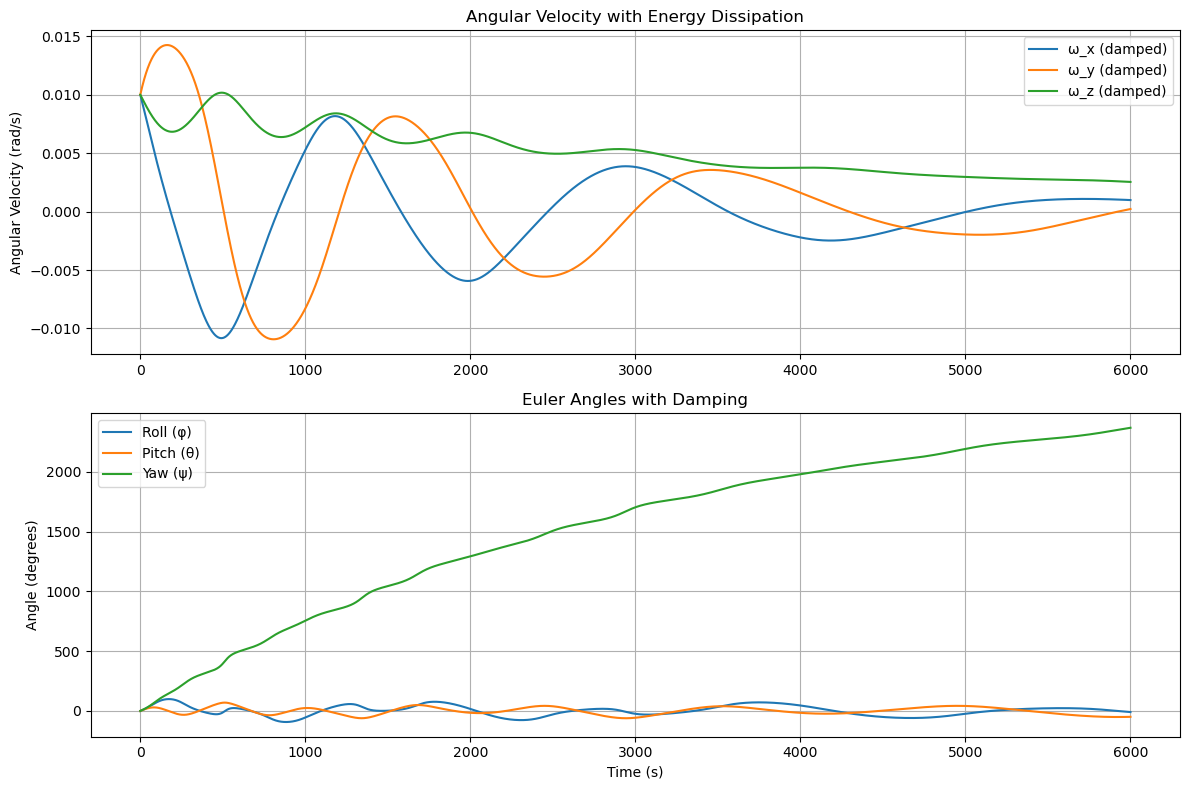

In [5]:
%reset -f
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Constants and parameters
mu = 3.986004418e14
R_earth = 6371e3
altitude = 500e3
R = R_earth + altitude

I_x, I_y, I_z = 100.0, 150.0, 200.0

# Damping coefficients
c_x, c_y, c_z = 0.05, 0.05, 0.05

# Initial state [φ, θ, ψ, ωx, ωy, ωz]
initial_angles = np.array([0.0, 0.0, 0.0])
initial_omega = np.array([0.01, 0.01, 0.01])
state0 = np.concatenate((initial_angles, initial_omega))

# Time array
t = np.linspace(0, 6000, 6001)

def satellite_dynamics_damped(state, t):
    # Unpack state
    φ, θ, ψ, ωx, ωy, ωz = state

    # Gravity gradient torque
    Mx_gg = (-3 * mu / R**3) * (I_z - I_y) * np.sin(φ)*np.cos(φ)*np.cos(θ)**2
    My_gg = (-3 * mu / R**3) * (I_z - I_x) * np.sin(θ)*np.cos(φ)*np.cos(θ)
    Mz_gg = (-3 * mu / R**3) * (I_y - I_x) * np.sin(θ)*np.sin(φ)*np.cos(θ)

    # Damping torque
    Mx = Mx_gg - c_x * ωx
    My = My_gg - c_y * ωy
    Mz = Mz_gg - c_z * ωz

    # Angular acceleration
    dωx = (Mx - (I_z - I_y)*ωy*ωz) / I_x
    dωy = (My - (I_x - I_z)*ωz*ωx) / I_y
    dωz = (Mz - (I_y - I_x)*ωx*ωy) / I_z

    # Kinematic equations
    dφ = ωx + np.sin(φ)*np.tan(θ)*ωy + np.cos(φ)*np.tan(θ)*ωz
    dθ = np.cos(φ)*ωy - np.sin(φ)*ωz
    dψ = (np.sin(φ)/np.cos(θ))*ωy + (np.cos(φ)/np.cos(θ))*ωz

    return [dφ, dθ, dψ, dωx, dωy, dωz]

# Solve ODE
solution_damped = odeint(satellite_dynamics_damped, state0, t)

# Extract components
φ_d, θ_d, ψ_d = solution_damped[:, 0], solution_damped[:, 1], solution_damped[:, 2]
ωx_d, ωy_d, ωz_d = solution_damped[:, 3], solution_damped[:, 4], solution_damped[:, 5]

# Plot
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(t, ωx_d, label='ω_x (damped)')
plt.plot(t, ωy_d, label='ω_y (damped)')
plt.plot(t, ωz_d, label='ω_z (damped)')
plt.title('Angular Velocity with Energy Dissipation')
plt.ylabel('Angular Velocity (rad/s)')
plt.legend()
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(t, np.degrees(φ_d), label='Roll (φ)')
plt.plot(t, np.degrees(θ_d), label='Pitch (θ)')
plt.plot(t, (np.degrees(ψ_d)), label='Yaw (ψ)')
plt.title('Euler Angles with Damping')
plt.xlabel('Time (s)')
plt.ylabel('Angle (degrees)')
plt.legend()
plt.grid()

plt.tight_layout()
plt.savefig('Part 3.png', format='png', dpi=300)
plt.show()


## Part 4: Apply Kalman Filter  

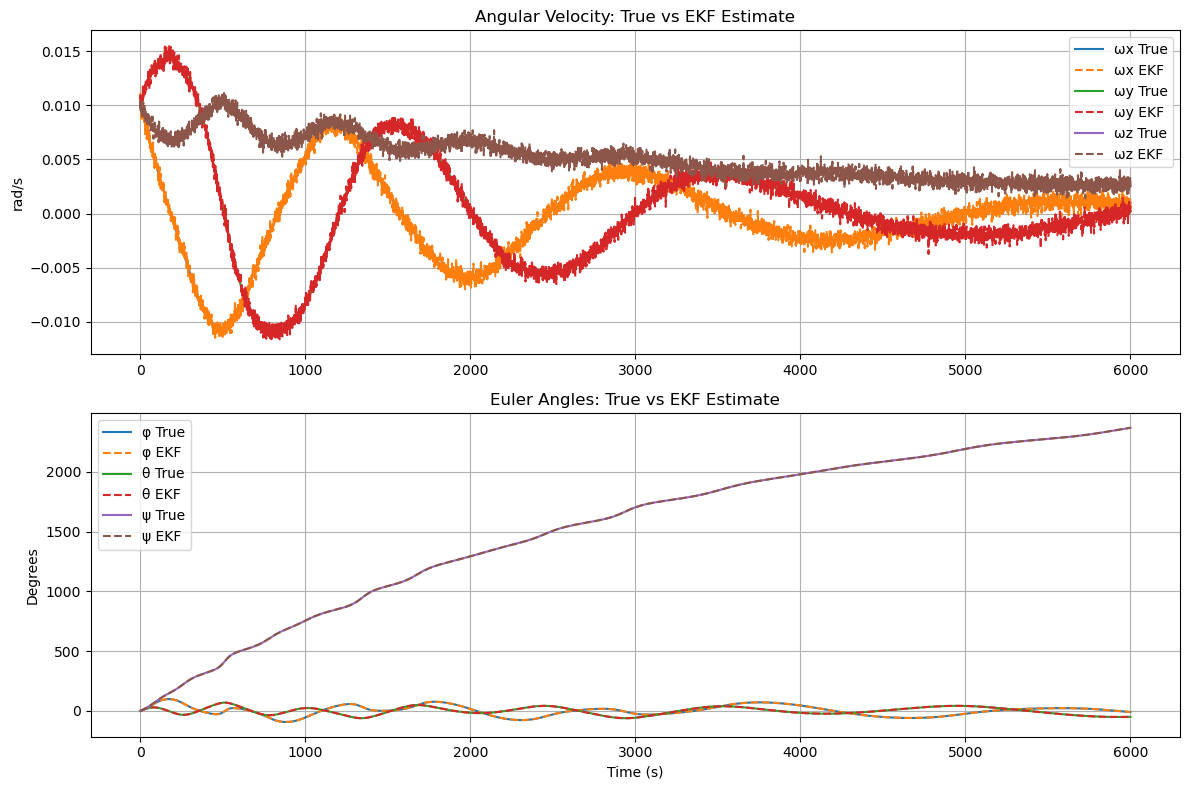

In [6]:
%reset -f
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Constants
mu = 3.986004418e14  # Earth's gravitational parameter (m^3/s^2)
R_earth = 6371e3     # Earth's radius (m)
altitude = 500e3     # Satellite altitude (m)
R = R_earth + altitude

# Inertia (kg·m²)
I_x, I_y, I_z = 100, 150, 200
I = np.diag([I_x, I_y, I_z])

# Initial state: [φ, θ, ψ, ωx, ωy, ωz]
state0 = np.array([0, 0, 0, 0.01, 0.01, 0.01])

# Time vector
t = np.linspace(0, 6000, 6001)  # 100 minutes at 1s interval
dt = t[1] - t[0]

# Satellite dynamics with damping
def satellite_dynamics_damped(state, t):
    φ, θ, ψ, ωx, ωy, ωz = state
    ω = np.array([ωx, ωy, ωz])

    # Gravity gradient torque
    Mx = (-3 * mu / R**3) * (I_z - I_y) * np.sin(φ)*np.cos(φ)*np.cos(θ)**2
    My = (-3 * mu / R**3) * (I_z - I_x) * np.sin(θ)*np.cos(φ)*np.cos(θ)
    Mz = (-3 * mu / R**3) * (I_y - I_x) * np.sin(θ)*np.sin(φ)*np.cos(θ)
    M = np.array([Mx, My, Mz])

    # Damping torque (simple linear model)
    damping_coeff = 0.05
    M_damping = -damping_coeff * ω

    # Total torque
    M_total = M + M_damping

    # Angular acceleration
    ω_dot = np.linalg.inv(I) @ (M_total - np.cross(ω, I @ ω))

    # Kinematic equations
    dφ = ωx + np.sin(φ)*np.tan(θ)*ωy + np.cos(φ)*np.tan(θ)*ωz
    dθ = np.cos(φ)*ωy - np.sin(φ)*ωz
    dψ = (np.sin(φ)/np.cos(θ))*ωy + (np.cos(φ)/np.cos(θ))*ωz

    return [dφ, dθ, dψ, *ω_dot]

# Simulate true dynamics
true_states = odeint(satellite_dynamics_damped, state0, t)
φ_true, θ_true, ψ_true = true_states[:, 0], true_states[:, 1], true_states[:, 2]
ωx_true, ωy_true, ωz_true = true_states[:, 3], true_states[:, 4], true_states[:, 5]

# Simulate noisy measurements
np.random.seed(0)
noise_std = np.array([0.001]*3 + [0.0005]*3)  # angles + angular velocity
measurements = true_states + np.random.normal(0, noise_std, true_states.shape)

# EKF initialization
n = 6
x_est = np.copy(state0)
P = np.eye(n) * 0.01
Q = np.eye(n) * 1e-6
R_cov = np.diag(noise_std**2)
H = np.eye(n)

estimates = []

def dynamics_jacobian():
    F = np.eye(n)
    F[0, 3] = 1
    F[1, 4] = 1
    F[2, 5] = 1
    return F

for k in range(len(t)):
    # Predict step
    dx = np.array(satellite_dynamics_damped(x_est, t[k]))
    x_pred = x_est + dx * dt
    F = dynamics_jacobian()
    P_pred = F @ P @ F.T + Q

    # Update step
    z = measurements[k]
    y = z - x_pred
    S = H @ P_pred @ H.T + R_cov
    K = P_pred @ H.T @ np.linalg.inv(S)
    x_est = x_pred + K @ y
    P = (np.eye(n) - K @ H) @ P_pred

    estimates.append(x_est)

estimates = np.array(estimates)
φ_kf, θ_kf, ψ_kf = estimates[:, 0], estimates[:, 1], estimates[:, 2]
ωx_kf, ωy_kf, ωz_kf = estimates[:, 3], estimates[:, 4], estimates[:, 5]

# --- Plotting ---
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(t, ωx_true, label='ωx True')
plt.plot(t, ωx_kf, '--', label='ωx EKF')
plt.plot(t, ωy_true, label='ωy True')
plt.plot(t, ωy_kf, '--', label='ωy EKF')
plt.plot(t, ωz_true, label='ωz True')
plt.plot(t, ωz_kf, '--', label='ωz EKF')
plt.title('Angular Velocity: True vs EKF Estimate')
plt.ylabel('rad/s')
plt.legend()
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(t, np.degrees(φ_true), label='φ True')
plt.plot(t, np.degrees(φ_kf), '--', label='φ EKF')
plt.plot(t, np.degrees(θ_true), label='θ True')
plt.plot(t, np.degrees(θ_kf), '--', label='θ EKF')
plt.plot(t, np.degrees(ψ_true), label='ψ True')
plt.plot(t, np.degrees(ψ_kf), '--', label='ψ EKF')
plt.title('Euler Angles: True vs EKF Estimate')
plt.xlabel('Time (s)')
plt.ylabel('Degrees')
plt.legend()
plt.grid()

plt.tight_layout()
plt.savefig('Part 4.png', format='png', dpi=300)
plt.show()
